# Topic Modeling of the American Presidential Inaugarations dataset with LDA

## Set up

### Install necessary packages

In [1]:
#pip install --upgrade opendatasets numpy pandas scipy scikit-learn matplotlib seaborn gensim wordcloud nltk

### Import packages

In [63]:
import os
import numpy as np
import pandas as pd
import gensim as gm
import seaborn as sns
import opendatasets as od
import regex as re
import string
import nltk
from pprint import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud as wc
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Download Data
For this step, we need the `kaggle` api which was installed above. Please follow these instructions:
1. Create a kaggle account
2. Navigate to https://kaggle.com/`username`/account -> `API` -> `Create New API Token` 
3. Move the downloaded `kaggle.json` file to `~/.kaggle/` using a command such as `mv ~/Downloads/kaggle.json ~/.kaggle/` from the CLI or using your machine's gui`
4. Open the kaggle.json you should see something like `{"username":"[USERNAME]","key":"[KEY]"}`. Copy `KEY` to your clipboard
5. Run the command below and follow the prompts
6. Done! You should see `inaug_speeches.csv` in `./data` dir.

In [3]:
# os.makedirs('../data',exist_ok=True)
# od.download('https://www.kaggle.com/datasets/adhok93/presidentialaddress',data_dir='../data',force=True)
# os.rename('../data/presidentialaddress/inaug_speeches.csv','../data/inaug_speeches.csv')
# os.rmdir('../data/presidentialaddress')

### Helper Functions

In [50]:
def clean_raw_data(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text
def tokenize_words(txt):
    tokenized = word_tokenize(txt)
    return tokenized

def remove_stopwords(tokenized_txt):
    stop_words = nltk.corpus.stopwords.words('english')
    cleaned_text_array = [word for word in tokenized_txt if word not in stop_words]
    return cleaned_text_array

def word_lemmatizer(tokenized_text_without_stopwords):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in tokenized_text_without_stopwords]
    return ' '.join(lemmatized)
def preprocess(raw_data):
    # Clean Speech Text
    raw_data["text"] = raw_data["text"].apply(lambda x: clean_raw_data(x))
    raw_data['tokenized_text']=raw_data['text'].apply(tokenize_words)
    raw_data['Inaugural Address']=raw_data['Inaugural Address'].apply(lambda x: 2 if 'second' in x.lower() else 1)
    raw_data['tokenized_text_without_stopwords'] = raw_data['tokenized_text'].apply(lambda x: remove_stopwords(x))
    raw_data['lemmatized_tok_txt_wo_stopwords'] = raw_data['tokenized_text_without_stopwords'].apply(lambda x: word_lemmatizer(x))
    additional_stop_words = ["fellow","america", 'today', 'thing']
    stop_words_aggr = text.ENGLISH_STOP_WORDS.union(additional_stop_words)
    tfidf = TfidfVectorizer(stop_words=stop_words_aggr, ngram_range = (1,1), max_df = .8, min_df = .01)
    tfidf_transformed = tfidf.fit_transform(raw_data.lemmatized_tok_txt_wo_stopwords)
    return raw_data,tfidf_transformed,tfidf

In [79]:
def word2topic_gensim(lda_model,text,id2word,n_topics,n_terms=5):
    top_k_words = lda_model.show_topics(num_topics = n_topics,num_words=n_terms)
    print(len(top_k_words))
    top_k_words = {i:tok_k_words[i][1].split("\"")[1::2] for i in range(len(top_k_words))}
    return top_k_words
def word2topic_sklearn(word_topic_probs,n_terms,n_topics,words):
    n_topics = len(word_topic_probs)
    words = {ind:word for word,ind in words.items()}
    words = pd.DataFrame(words.values(),columns=['Word'])
    top_k_inds = np.argsort(word_topic_probs[:n_topics,:],axis=-1)
    top_k_inds = top_k_inds[:,:-n_terms-1:-1]
    terms={}
    for i in range(n_topics):
        inds = top_k_inds[i]
        terms[i] = [word for word in words.iloc[inds]['Word']]
    return terms
def topics2docs_gensim(model,docs,n_topics):
    topics = {}
    for i in range(docs.shape[0]):
        dist = model.get_document_topics(gm.matutils.Sparse2Corpus(X)[i])
        dist_array = np.array([prob[-1] for prob in dist])
        sorted_dist_array = np.argsort(dist_array)
        top_k_topics = sorted_dist_array[:-n_topics-1:-1]
        topics[i]=top_k_topics
    return topics
def topics2docs_sklearn(doc_topic_probs,n_topics=3):
    top_k_inds = np.argsort(doc_topic_probs,axis=-1)
    top_k_inds = top_k_inds[:,:-1*n_topics-1:-1]
    topics = {i:top_k_inds[i,:] for i in range(len(doc_topic_probs))}
    return topics
# def label_data(date,by='Era'):
#     US_ERAS={0:(1783,1815),1:(1815,1861),2:(1861,1877),3:(1877,1900),4:(1900,1929),5:(1929,1945),6:(1945,1968),7:(1968,2022)}
#     year = date.split(',')[-1]
#     year = int(year)
#     for era,length in US_ERAS.items():
#         if year >= length[0] and year < length[1]:
#             return era
#     return -1
# def word_count(speeches):
#     wc = {}
#     for word in set([word for speech in speeches for word in speech.split()]):
#         for speech in speeches:
#             if word in speech:
#                 if word not in wc:
#                     wc[word] = 0
#                 else:
#                     wc[word] += 1
#     for word in wc.keys():
#         wc[word] = wc[word]/len(speeches)
#     return wc

## LDA on Presidential Inaugural Addresses Dataset

### Data Exploration

#### Load Data

In [51]:
speeches_df_raw = pd.read_csv('../data/inaug_speeches.csv',encoding='latin1')
speeches_df_raw.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and o...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again cal...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in ..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CA...
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to ..."


In [7]:
print('Basic statistics about raw data:')
print(f'Number of Speeches (data points): {len(speeches_df_raw)}')
print(f'Total number of unique words before filtering: {len(set([word for speech in speeches_df_raw.text.tolist() for word in speech.split()]))}')
print(f'Average word length before filtering: {np.mean([len(word) for word in set([word for speech in speeches_df_raw.text.tolist() for word in speech.split()])])}')
print(f'Average speech length before filtering: {int(np.round(np.mean(speeches_df_raw.text.apply(lambda x:len(x)))))}')

Basic statistics about raw data:
Number of Speeches (data points): 58
Total number of unique words before filtering: 15087
Average word length before filtering: 8.260621727314907
Average speech length before filtering: 13819


#### Filter/preprocess data

In [52]:
speeches_df_preprocessed,X,tfidf = preprocess(speeches_df_raw)
speeches_df_preprocessed.head()

,Unnamed: 0,Name,Inaugural Address,Date,text,tokenized_text,tokenized_text_without_stopwords,lemmatized_tok_txt_wo_stopwords
0,4,George Washington,1,"Thursday, April 30, 1789",fellow citizens of the senate and o...,"[fellow, citizens, of, the, senate, and, of, t...","[fellow, citizens, senate, house, representati...",fellow citizen senate house representative amo...
1,5,George Washington,2,"Monday, March 4, 1793",fellow citizens i am again cal...,"[fellow, citizens, i, am, again, called, upon,...","[fellow, citizens, called, upon, voice, countr...",fellow citizen called upon voice country execu...
2,6,John Adams,1,"Saturday, March 4, 1797",when it was first perceived in ...,"[when, it, was, first, perceived, in, early, t...","[first, perceived, early, times, middle, cours...",first perceived early time middle course ameri...
3,7,Thomas Jefferson,1,"Wednesday, March 4, 1801",friends and fellow citizens ca...,"[friends, and, fellow, citizens, called, upon,...","[friends, fellow, citizens, called, upon, unde...",friend fellow citizen called upon undertake du...
4,8,Thomas Jefferson,2,"Monday, March 4, 1805",proceeding fellow citizens to ...,"[proceeding, fellow, citizens, to, that, quali...","[proceeding, fellow, citizens, qualification, ...",proceeding fellow citizen qualification consti...


In [9]:
print('Basic statistics about filtered data:')
print(f'Number of Speeches (data points): {len(speeches_df_preprocessed)}')
print(f'Total number of unique words after filtering: {X.shape[-1]}')
print(f'Average word length before filtering: {np.mean([len(word) for word in tfidf.vocabulary_.keys()])}')
print(f'Average speech length after filtering: {int(np.round(np.mean(speeches_df_preprocessed.lemmatized_tok_txt_wo_stopwords.apply(lambda x:len(x)))))}')

Basic statistics about filtered data:
Number of Speeches (data points): 58
Total number of unique words after filtering: 7771
Average word length before filtering: 7.855488354137177
Average speech length after filtering: 8510


#### Visualize Data

Text(0.5, 1.0, 'Top 100 words in Presidential Inaugural Addresses')

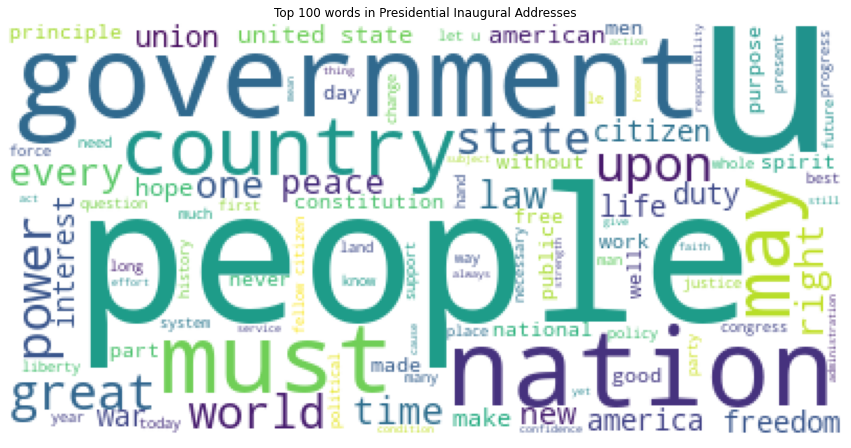

In [10]:
fig,axs = plt.subplots(1,figsize=(15,15))
axs.imshow(wc(background_color='white',max_words=100).generate(''.join(speeches_df_preprocessed.lemmatized_tok_txt_wo_stopwords.tolist())))
axs.axis('off')
axs.set_title('Top 100 words in Presidential Inaugural Addresses')

### Perform LDA on dataset

In [65]:
scores = []
for n_topics in tqdm(np.arange(10,210,10)):
    lda_gensim = gm.models.ldamodel.LdaModel(corpus=gm.matutils.Sparse2Corpus(X),
                                         num_topics=n_topics,
                                         id2word=id2word
                                        )
    coherence_score = gm.models.coherencemodel.CoherenceModel(model=lda_gensim, texts=speeches_df_preprocessed['lemmatized_tok_txt_wo_stopwords'].apply(lambda x:x.split()), dictionary=id2word, coherence='c_v').get_coherence()
    scores.append(coherence_score)
print(f'Best Number of Topics:{np.arange(10,210,10)[np.argmax(scores)]} with coherence score of {max(scores)}')

  0%|          | 0/20 [00:00<?, ?it/s]

Best Number of Topics:110 with coherence score of 0.6310523684979004


Text(0, 0.5, 'Coherence Score')

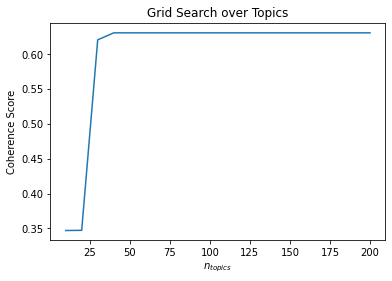

In [67]:
plt.plot(np.arange(10,210,10),scores)
plt.title('Grid Search over Topics')
plt.xlabel(r'$n_{topics}$')
plt.ylabel('Coherence Score')

#### Get $P(T|D),P(T|W)$

In [70]:
N_TOPICS = 110
print(f'Number of topics to be found: {N_TOPICS}')
lda_sklearn = LDA(n_components=N_TOPICS)
logits = lda_sklearn.fit_transform(X)
logits.shape,lda_sklearn.components_.shape

Number of topics to be found: 110


((58, 110), (110, 7771))

In [71]:
id2word = gm.corpora.Dictionary(speeches_df_preprocessed['lemmatized_tok_txt_wo_stopwords'].apply(lambda x: x.split()))
lda_gensim = gm.models.ldamodel.LdaModel(corpus=gm.matutils.Sparse2Corpus(X),
                                         num_topics=N_TOPICS,
                                         id2word=id2word
                                        )

#### Get top $N$ terms occuring in each of the $T$ topics

In [75]:
N_TERMS = 5
N_TOPICS_TO_DISPLAY=10
topic_words_sklearn = word2topic_sklearn(lda_sklearn.components_,words=tfidf.vocabulary_,n_terms=N_TERMS,n_topics=N_TOPICS_TO_DISPLAY)
print(f'Top {N_TERMS} words occuring in each of the {N_TOPICS} topics using sklearn')
for topic,terms in topic_words_sklearn.items():
    terms = ', '.join(terms)
    print(f'Topic {topic}: {terms}')

Top 5 words occuring in each of the 110 topics using sklearn
Topic 0: invaded, exacting, unobtrusive, wrongfully, awarded
Topic 1: justification, blood, cultural, large, therewith
Topic 2: remainder, variety, tasked, old, valley
Topic 3: ignored, sectional, consummation, million, multiplied
Topic 4: guest, circle, hillside, artist, million
Topic 5: rapid, middle, executive, flocking, uncompromising
Topic 6: strangle, riper, destroyed, enforcing, seeking
Topic 7: ignored, sectional, consummation, million, multiplied
Topic 8: ignored, sectional, consummation, million, multiplied
Topic 9: ignored, sectional, consummation, million, multiplied
Topic 10: ignored, sectional, consummation, million, multiplied
Topic 11: ignored, sectional, consummation, million, multiplied
Topic 12: involvement, check, presence, mormon, tender
Topic 13: ignored, sectional, consummation, million, multiplied
Topic 14: disappeared, ascendancy, direction, calvin, montana
Topic 15: ignored, sectional, consummation, 

In [80]:
topic_words_gensim = word2topic_gensim(lda_gensim,X,id2word,N_TOPICS,N_TERMS)
print(f'Top {N_TERMS} words occuring in each of the {N_TOPICS} topics using gensim')
for topic,terms in topic_words_gensim.items():
    terms = ', '.join(terms)
    print(f'Topic {topic}: {terms}')

110


NameError: name 'tok_k_words' is not defined

#### Get top $20\%$ of topics assigned to each document

In [53]:
N_TOPICS_PER_DOC=5
print(f'Top {N_TOPICS_PER_DOC} topics appearing in each of the {X.shape[0]} documents using sklearn')
topic_docs = topics2docs_sklearn(logits,N_TOPICS_PER_DOC)
for doc,topics in topic_docs.items():
    topics = ', '.join([str(topic) for topic in topics])
    name = speeches_df_preprocessed.iloc[doc]['Name']
    ia = speeches_df_preprocessed.iloc[doc]['Inaugural Address']
    print(f'{name}\'s Inaugural Address #{ia}: {topics}')

Top 5 topics appearing in each of the 58 documents using sklearn
George Washington's Inaugural Address #1: 7, 2, 18, 19, 17
George Washington's Inaugural Address #2: 7, 2, 18, 17, 19
John Adams's Inaugural Address #1: 19, 2, 18, 17, 16
Thomas Jefferson's Inaugural Address #1: 2, 18, 17, 19, 4
Thomas Jefferson's Inaugural Address #2: 2, 18, 19, 17, 7
James Madison's Inaugural Address #1: 18, 2, 19, 16, 17
James Madison's Inaugural Address #2: 7, 2, 19, 18, 17
James Monroe's Inaugural Address #1: 2, 16, 19, 18, 17
James Monroe's Inaugural Address #2: 2, 4, 19, 18, 17
John Quincy Adams's Inaugural Address #1: 2, 16, 19, 18, 17
Andrew Jackson's Inaugural Address #1: 18, 2, 19, 17, 7
Andrew Jackson's Inaugural Address #2: 2, 5, 19, 18, 17
Martin Van Buren's Inaugural Address #1: 2, 8, 18, 19, 17
William Henry Harrison's Inaugural Address #1: 2, 14, 19, 18, 17
James Knox Polk's Inaugural Address #1: 19, 2, 18, 17, 14
Zachary Taylor's Inaugural Address #1: 2, 19, 6, 18, 17
Franklin Pierce's I

In [56]:
N_TOPICS_PER_DOC=5
print(f'Top {N_TOPICS_PER_DOC} topics appearing in each of the {X.shape[0]} documents using gensimn')
topic_docs_gensim = topics2docs_gensim(lda_gensim,X,N_TOPICS_PER_DOC)
for doc,topics in topic_docs_gensim.items():
    topics = ', '.join([str(topic) for topic in topics])
    name = speeches_df_preprocessed.iloc[doc]['Name']
    ia = speeches_df_preprocessed.iloc[doc]['Inaugural Address']
    print(f'{name}\'s Inaugural Address #{ia}: {topics}')

Top 5 topics appearing in each of the 58 documents using gensimn
George Washington's Inaugural Address #1: 16, 13, 1, 19, 8
George Washington's Inaugural Address #2: 1, 16, 19, 8, 2
John Adams's Inaugural Address #1: 16, 1, 19, 8, 2
Thomas Jefferson's Inaugural Address #1: 1, 13, 16, 19, 8
Thomas Jefferson's Inaugural Address #2: 16, 1, 13, 19, 8
James Madison's Inaugural Address #1: 1, 16, 9, 8, 2
James Madison's Inaugural Address #2: 16, 1, 19, 8, 2
James Monroe's Inaugural Address #1: 1, 19, 18, 2, 3
James Monroe's Inaugural Address #2: 16, 1, 19, 8, 2
John Quincy Adams's Inaugural Address #1: 1, 16, 13, 19, 8
Andrew Jackson's Inaugural Address #1: 1, 16, 19, 8, 2
Andrew Jackson's Inaugural Address #2: 1, 16, 13, 19, 8
Martin Van Buren's Inaugural Address #1: 1, 16, 13, 19, 8
William Henry Harrison's Inaugural Address #1: 16, 19, 8, 1, 2
James Knox Polk's Inaugural Address #1: 1, 16, 19, 8, 2
Zachary Taylor's Inaugural Address #1: 16, 1, 19, 8, 2
Franklin Pierce's Inaugural Address 

#### Visualize Topic Clusterings with *t-SNE*

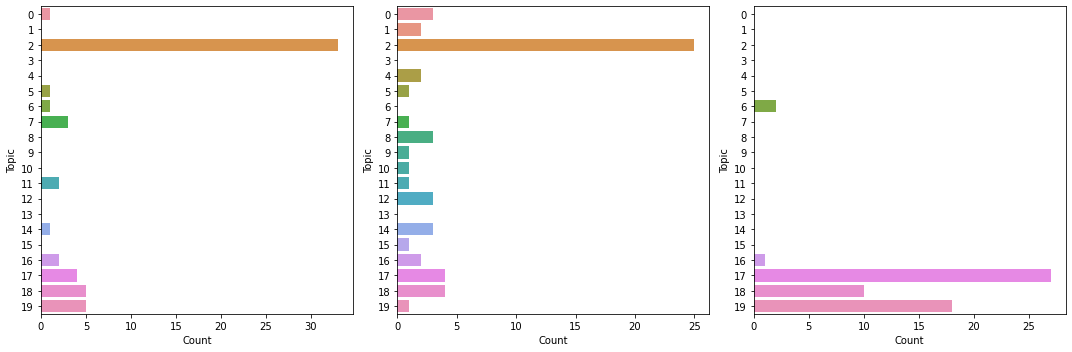

In [57]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    count = {k:0 for k in range(N_TOPICS)}
    for j in [topics[i] for topics in topic_docs.values()]:
        count[j] += 1
    count = pd.DataFrame(count.values(),columns=['Count'])
    count['Topic'] = np.arange(len(count))
    sns.barplot(count,x='Count',y='Topic',orient='horizontal',ax=axs[i])
fig.tight_layout()

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


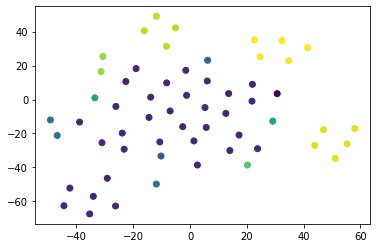

In [58]:
clusters = TSNE(n_components = 2).fit_transform(logits)
plt.scatter(clusters[:,0],clusters[:,1],c = [topic[0] for topic in topic_docs.values()])